In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Matrix Factorization

In [2]:
ratings = pd.read_csv("../ml-latest-small/ratings.csv")
ratings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


In [3]:
train_df, test_df = train_test_split(ratings, test_size=0.2)

#resetting indices to avoid indexing errors in the future
train_df = train_df.reset_index()[['userId', 'movieId', 'rating']]
test_df = test_df.reset_index()[['userId', 'movieId', 'rating']]

In [4]:
train_user_data = train_df.userId
train_item_data = train_df.movieId
train_ratings_data = train_df.rating.tolist()

test_user_data = test_df.userId
test_item_data = test_df.movieId
test_ratings_data = test_df.rating.tolist()

In [5]:
n_users = ratings.userId.max()
n_movies = ratings.movieId.max()
train_adj_matrix = csr_matrix((train_ratings_data, (train_user_data - 1, train_item_data - 1)), shape = (n_users, n_movies))
train_adj_matrix.shape

test_adj_matrix = csr_matrix((test_ratings_data, (test_user_data - 1, test_item_data - 1)), shape = (n_users, n_movies))
test_adj_matrix.shape
# userId and movieId will be offset by -1

(610, 193609)

In [6]:
K = 40
U = np.random.rand(n_users, K)
M = np.random.rand(n_movies, K)

In [7]:
def cost(adj_matrix, U, M):
    predicted_ratings = np.dot(U, M)
    csr_predicted = csr_matrix(predicted_ratings)
    csr_residuals = adj_matrix - csr_predicted
    D = adj_matrix.nonzero()
    e2 = list(map(lambda x : x**2, csr_residuals[D].tolist()[0]))
    mse = sum(e2) / len(D[0])
    return mse

In [8]:
def Gradientdescent(R, R_test, U, M, K, epochs = 500, gamma = 0.0015, beta = 0.06, min_delta = 0.001):
    # gamma refers to learning rate, beta refers to regularization term
    M = M.T
    train_mse_lst = []
    test_mse_lst = []
    # set up early stopping
    best_test_mse = float('inf')
    patience = 5 # number of epochs to wait before stopping if validation MSE does not improve

    for epoch in tqdm(range(epochs)):
        for i in range(n_users):
            row = R.getrow(i).toarray()[0]
            for j in range(n_movies):
                if row[j] > 0:
                    eij = row[j] - np.dot(U[i,:], M[:,j])
                    for k in range(K):
                        U[i][k] = U[i][k] + gamma * (eij * M[k][j] - beta * U[i][k])
                        M[k][j] = M[k][j] + gamma * (eij * U[i][k] - beta * M[k][j])

        train_mse = cost(R, U, M)
        train_mse_lst.append(train_mse)
        test_mse = cost(R_test, U, M)
        test_mse_lst.append(test_mse)

        # Check if the test MSE has improved
        if test_mse < best_test_mse - min_delta:
            # Update the best test MSE and the number of epochs since the best test MSE
            best_test_mse = test_mse
            epochs_since_best = 0
        else:
            # Increment the number of epochs since the best test MSE
            epochs_since_best += 1

        if epochs_since_best >= patience:
            print(f"Stopping early after epoch {epoch + 1} due to no improvement in test MSE.")
            break

        print('Epoch', epoch + 1, 'validation MSE', test_mse)
    return U, M.T, train_mse_lst, test_mse_lst

In [9]:
P, Q, train_errors, test_errors = Gradientdescent(train_adj_matrix, test_adj_matrix, U, M, K)
R_hat = np.dot(P, Q.T)

  0%|          | 1/500 [00:59<8:16:27, 59.69s/it]

Epoch 1 validation MSE 2.9957865198048053


  0%|          | 2/500 [02:04<8:38:52, 62.51s/it]

Epoch 2 validation MSE 2.095034307556018


  1%|          | 3/500 [03:00<8:16:08, 59.90s/it]

Epoch 3 validation MSE 1.7502468132591515


  1%|          | 4/500 [03:56<8:01:29, 58.25s/it]

Epoch 4 validation MSE 1.5581106165267082


  1%|          | 5/500 [04:52<7:54:29, 57.52s/it]

Epoch 5 validation MSE 1.4322800853158697


  1%|          | 6/500 [05:49<7:50:15, 57.12s/it]

Epoch 6 validation MSE 1.342226480069281


  1%|▏         | 7/500 [06:45<7:47:33, 56.90s/it]

Epoch 7 validation MSE 1.27414668100478


  2%|▏         | 8/500 [07:42<7:46:01, 56.83s/it]

Epoch 8 validation MSE 1.2207631013130784


  2%|▏         | 9/500 [08:39<7:46:36, 57.02s/it]

Epoch 9 validation MSE 1.177803094136136


  2%|▏         | 10/500 [09:37<7:46:31, 57.12s/it]

Epoch 10 validation MSE 1.1425525127527445


  2%|▏         | 11/500 [10:34<7:45:42, 57.14s/it]

Epoch 11 validation MSE 1.1131825923363001


  2%|▏         | 12/500 [11:31<7:45:11, 57.20s/it]

Epoch 12 validation MSE 1.088404937028613


  3%|▎         | 13/500 [12:28<7:43:52, 57.15s/it]

Epoch 13 validation MSE 1.0672802588340617


  3%|▎         | 14/500 [13:25<7:42:52, 57.15s/it]

Epoch 14 validation MSE 1.0491052440252477


  3%|▎         | 15/500 [14:23<7:42:20, 57.20s/it]

Epoch 15 validation MSE 1.0333419346638506


  3%|▎         | 16/500 [15:20<7:42:18, 57.31s/it]

Epoch 16 validation MSE 1.019571647699547


  3%|▎         | 17/500 [16:20<7:46:58, 58.01s/it]

Epoch 17 validation MSE 1.0074637882380462


  4%|▎         | 18/500 [17:21<7:53:01, 58.88s/it]

Epoch 18 validation MSE 0.9967540987307507


  4%|▍         | 19/500 [18:19<7:50:46, 58.73s/it]

Epoch 19 validation MSE 0.9872291051612034


  4%|▍         | 20/500 [19:18<7:49:18, 58.66s/it]

Epoch 20 validation MSE 0.9787147578177254


  4%|▍         | 21/500 [20:16<7:47:32, 58.56s/it]

Epoch 21 validation MSE 0.9710679845630904


  4%|▍         | 22/500 [21:14<7:44:34, 58.32s/it]

Epoch 22 validation MSE 0.9641703109816167


  5%|▍         | 23/500 [22:12<7:42:49, 58.22s/it]

Epoch 23 validation MSE 0.9579229754147066


  5%|▍         | 24/500 [23:09<7:40:31, 58.05s/it]

Epoch 24 validation MSE 0.9522431434770247


  5%|▌         | 25/500 [24:07<7:38:46, 57.95s/it]

Epoch 25 validation MSE 0.9470609434310412


  5%|▌         | 26/500 [25:05<7:37:35, 57.92s/it]

Epoch 26 validation MSE 0.9423171226806037


  5%|▌         | 27/500 [26:03<7:36:28, 57.90s/it]

Epoch 27 validation MSE 0.9379611799258644


  6%|▌         | 28/500 [27:01<7:36:26, 58.02s/it]

Epoch 28 validation MSE 0.9339498655089665


  6%|▌         | 29/500 [27:59<7:34:07, 57.85s/it]

Epoch 29 validation MSE 0.9302459694856381


  6%|▌         | 30/500 [28:56<7:33:08, 57.85s/it]

Epoch 30 validation MSE 0.926817336443128


  6%|▌         | 31/500 [29:54<7:31:35, 57.77s/it]

Epoch 31 validation MSE 0.9236360603439826


  6%|▋         | 32/500 [30:54<7:35:00, 58.33s/it]

Epoch 32 validation MSE 0.9206778232480146


  7%|▋         | 33/500 [31:51<7:31:22, 57.99s/it]

Epoch 33 validation MSE 0.9179213497017693


  7%|▋         | 34/500 [32:48<7:28:09, 57.70s/it]

Epoch 34 validation MSE 0.9153479546099299


  7%|▋         | 35/500 [33:45<7:25:07, 57.44s/it]

Epoch 35 validation MSE 0.9129411670239099


  7%|▋         | 36/500 [34:42<7:22:53, 57.27s/it]

Epoch 36 validation MSE 0.9106864158578482


  7%|▋         | 37/500 [35:39<7:22:33, 57.35s/it]

Epoch 37 validation MSE 0.9085707663304795


  8%|▊         | 38/500 [36:37<7:22:03, 57.41s/it]

Epoch 38 validation MSE 0.9065826981214131


  8%|▊         | 39/500 [37:34<7:21:32, 57.47s/it]

Epoch 39 validation MSE 0.9047119179600192


  8%|▊         | 40/500 [38:31<7:19:24, 57.31s/it]

Epoch 40 validation MSE 0.9029492007397006


  8%|▊         | 41/500 [39:29<7:19:22, 57.43s/it]

Epoch 41 validation MSE 0.9012862543468108


  8%|▊         | 42/500 [40:26<7:17:31, 57.32s/it]

Epoch 42 validation MSE 0.8997156042729544


  9%|▊         | 43/500 [41:21<7:12:16, 56.75s/it]

Epoch 43 validation MSE 0.8982304947863644


  9%|▉         | 44/500 [42:20<7:16:20, 57.41s/it]

Epoch 44 validation MSE 0.8968248040097785


  9%|▉         | 45/500 [43:16<7:11:19, 56.88s/it]

Epoch 45 validation MSE 0.8954929707147967


  9%|▉         | 46/500 [44:11<7:06:52, 56.42s/it]

Epoch 46 validation MSE 0.8942299310193771


  9%|▉         | 47/500 [45:06<7:02:56, 56.02s/it]

Epoch 47 validation MSE 0.8930310634817391


 10%|▉         | 48/500 [46:02<7:00:06, 55.77s/it]

Epoch 48 validation MSE 0.8918921413355978


 10%|▉         | 49/500 [46:57<6:58:20, 55.66s/it]

Epoch 49 validation MSE 0.8908092908170733


 10%|█         | 50/500 [47:54<6:59:22, 55.92s/it]

Epoch 50 validation MSE 0.8897789547037316


 10%|█         | 51/500 [48:50<7:00:09, 56.15s/it]

Epoch 51 validation MSE 0.888797860325861


 10%|█         | 52/500 [49:46<6:58:36, 56.06s/it]

Epoch 52 validation MSE 0.8878629914261987


 11%|█         | 53/500 [50:42<6:57:14, 56.00s/it]

Epoch 53 validation MSE 0.8869715633402578


 11%|█         | 54/500 [51:38<6:55:20, 55.88s/it]

Epoch 54 validation MSE 0.8861210010498406


 11%|█         | 55/500 [52:35<6:57:49, 56.34s/it]

Epoch 55 validation MSE 0.8853089197288111


 11%|█         | 56/500 [53:32<6:57:36, 56.43s/it]

Epoch 56 validation MSE 0.8845331074566231


 11%|█▏        | 57/500 [54:27<6:53:35, 56.02s/it]

Epoch 57 validation MSE 0.8837915098217204


 12%|█▏        | 58/500 [55:22<6:51:04, 55.80s/it]

Epoch 58 validation MSE 0.8830822161767159


 12%|█▏        | 59/500 [56:17<6:48:43, 55.61s/it]

Epoch 59 validation MSE 0.8824034473408167


 12%|█▏        | 60/500 [57:13<6:47:48, 55.61s/it]

Epoch 60 validation MSE 0.8817535445728119


 12%|█▏        | 61/500 [58:08<6:45:42, 55.45s/it]

Epoch 61 validation MSE 0.8811309596624778


 12%|█▏        | 62/500 [59:03<6:44:12, 55.37s/it]

Epoch 62 validation MSE 0.8805342460082226


 13%|█▎        | 63/500 [59:58<6:43:04, 55.34s/it]

Epoch 63 validation MSE 0.8799620505665691


 13%|█▎        | 64/500 [1:00:54<6:41:59, 55.32s/it]

Epoch 64 validation MSE 0.8794131065738102


 13%|█▎        | 65/500 [1:01:49<6:40:44, 55.28s/it]

Epoch 65 validation MSE 0.8788862269528259


 13%|█▎        | 66/500 [1:02:44<6:40:42, 55.40s/it]

Epoch 66 validation MSE 0.8783802983294544


 13%|█▎        | 67/500 [1:03:40<6:39:24, 55.35s/it]

Epoch 67 validation MSE 0.8778942755917377


 14%|█▎        | 68/500 [1:04:35<6:39:14, 55.45s/it]

Epoch 68 validation MSE 0.8774271769338633


 14%|█▍        | 69/500 [1:05:30<6:37:44, 55.37s/it]

Epoch 69 validation MSE 0.8769780793336694


 14%|█▍        | 70/500 [1:06:26<6:36:41, 55.35s/it]

Epoch 70 validation MSE 0.8765461144185472


 14%|█▍        | 71/500 [1:07:22<6:38:11, 55.69s/it]

Epoch 71 validation MSE 0.8761304646799942


 14%|█▍        | 72/500 [1:08:19<6:38:58, 55.93s/it]

Epoch 72 validation MSE 0.8757303600017602


 15%|█▍        | 73/500 [1:09:16<6:40:51, 56.33s/it]

Epoch 73 validation MSE 0.8753450744703967


 15%|█▍        | 74/500 [1:10:14<6:42:26, 56.68s/it]

Epoch 74 validation MSE 0.8749739234407397


 15%|█▌        | 75/500 [1:11:11<6:43:04, 56.91s/it]

Epoch 75 validation MSE 0.8746162608317865


 15%|█▌        | 76/500 [1:12:08<6:43:03, 57.04s/it]

Epoch 76 validation MSE 0.8742714766313501


 15%|█▌        | 77/500 [1:13:05<6:42:16, 57.06s/it]

Epoch 77 validation MSE 0.8739389945898351


 16%|█▌        | 78/500 [1:14:03<6:41:33, 57.09s/it]

Epoch 78 validation MSE 0.8736182700861694


 16%|█▌        | 79/500 [1:15:00<6:40:25, 57.07s/it]

Epoch 79 validation MSE 0.8733087881502625


 16%|█▌        | 80/500 [1:15:57<6:39:46, 57.11s/it]

Epoch 80 validation MSE 0.873010061628175


 16%|█▌        | 81/500 [1:16:54<6:39:10, 57.16s/it]

Epoch 81 validation MSE 0.8727216294777397


 16%|█▋        | 82/500 [1:17:55<6:45:53, 58.26s/it]

Epoch 82 validation MSE 0.8724430551833096


 17%|█▋        | 83/500 [1:18:53<6:43:33, 58.07s/it]

Epoch 83 validation MSE 0.8721739252800335


 17%|█▋        | 84/500 [1:19:50<6:41:23, 57.89s/it]

Epoch 84 validation MSE 0.8719138479781419


 17%|█▋        | 85/500 [1:20:47<6:39:10, 57.71s/it]

Epoch 85 validation MSE 0.8716624518796388


 17%|█▋        | 86/500 [1:21:45<6:38:24, 57.74s/it]

Epoch 86 validation MSE 0.871419384779825


 17%|█▋        | 87/500 [1:22:41<6:34:24, 57.30s/it]

Epoch 87 validation MSE 0.871184312547024


 18%|█▊        | 88/500 [1:23:36<6:28:51, 56.63s/it]

Epoch 88 validation MSE 0.870956918074749


 18%|█▊        | 89/500 [1:24:31<6:24:18, 56.10s/it]

Epoch 89 validation MSE 0.8707369003005315


 18%|█▊        | 90/500 [1:25:27<6:21:50, 55.88s/it]

Epoch 90 validation MSE 0.8705239732868196


 18%|█▊        | 91/500 [1:26:22<6:19:45, 55.71s/it]

Epoch 91 validation MSE 0.8703178653592202


 18%|█▊        | 92/500 [1:27:17<6:17:33, 55.52s/it]

Epoch 92 validation MSE 0.8701183182980582


 19%|█▊        | 93/500 [1:28:12<6:15:42, 55.39s/it]

Epoch 93 validation MSE 0.869925086579518


 19%|█▉        | 94/500 [1:29:07<6:14:29, 55.34s/it]

Epoch 94 validation MSE 0.8697379366629623


 19%|█▉        | 95/500 [1:30:03<6:13:29, 55.33s/it]

Epoch 95 validation MSE 0.8695566463211761


 19%|█▉        | 96/500 [1:30:58<6:12:14, 55.28s/it]

Epoch 96 validation MSE 0.8693810040108378


 19%|█▉        | 97/500 [1:31:53<6:11:08, 55.26s/it]

Epoch 97 validation MSE 0.8692108082803455


 19%|█▉        | 97/500 [1:32:49<6:25:37, 57.41s/it]

Stopping early after epoch 98 due to no improvement in test MSE.


In [18]:
def save_plot_mse(train_mse_list, test_mse_list, idx):
    plt.style.use("dark_background")
    plt.plot(range(len(train_mse_list)), train_mse_list, label='Training MSE', color = 'indianred')
    plt.plot(range(len(test_mse_list)), test_mse_list, label='Test MSE', color = 'red')
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title("Plot of Training and Test MSE Against Number of Epochs")
    plt.legend()
    plt.savefig('mse' + str(idx) + ".png")

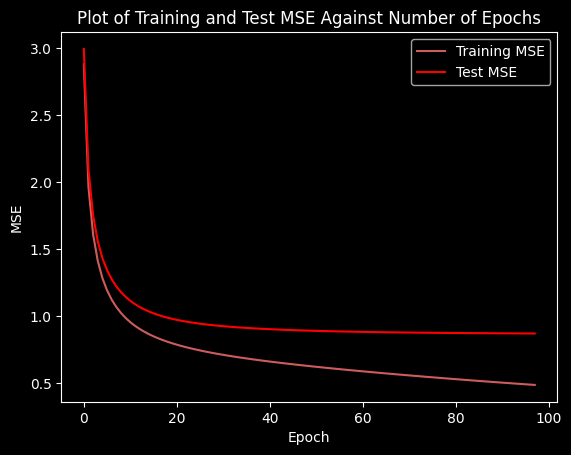

In [19]:
save_plot_mse(train_errors, test_errors, 3)

In [21]:
R_hat

array([[4.7778097 , 4.5057814 , 3.55861154, ..., 5.48633682, 4.7528133 ,
        5.8515359 ],
       [3.60786422, 3.31998799, 3.27170221, ..., 4.54736076, 4.646602  ,
        4.36406791],
       [2.78835737, 2.09959445, 2.17690637, ..., 3.48889844, 2.97061232,
        3.04856237],
       ...,
       [3.91590668, 3.30108676, 3.2193767 , ..., 4.34836517, 3.97819526,
        4.66191402],
       [3.31492148, 2.73384833, 2.88006121, ..., 3.34872859, 4.04643733,
        4.42289921],
       [3.73083809, 3.06113362, 2.96189201, ..., 3.92719352, 3.57346317,
        4.07294041]])

In [12]:
np.save('Modified_Algo/P_final.npy', P)
np.save('Modified_Algo/Q_final.npy', Q)
train_df.to_csv('Modified_Algo/train.csv')
test_df.to_csv('Modified_Algo/test.csv')
train_errors_array = np.array(train_errors)
test_errors_array = np.array(test_errors)
np.save('Modified_Algo/train_errors_final.npy', train_errors_array)
np.save('Modified_Algo/test_errors_final.npy', test_errors_array)

In [17]:
P2 = np.load('Modified_Algo/P_2.npy')
Q2 = np.load('Modified_Algo/Q_2.npy')
test_errors2 = np.load('Modified_Algo/test_errors_2.npy')
train_errors2 = np.load('Modified_Algo/train_errors_2.npy')